# Домашнее задание: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [1]:
import math

def calculate_entropy(counts):
    total = sum(counts)
    entropy = 0.0
    for count in counts:
        if count == 0:
            continue
        p = count / total
        entropy -= p * math.log(p)
    return round(entropy, 2)

class_counts = [8, 2]
entropy = calculate_entropy(class_counts)
print("Энтропия:", entropy)

Энтропия: 0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [2]:
def gini_impurity(class_counts):
    total = sum(class_counts)
    if total == 0:
        return 0
    return sum((count / total) * (1 - count / total) for count in class_counts)

def information_gain(parent_counts, left_counts, right_counts):
    H_parent = gini_impurity(parent_counts)
    N = sum(parent_counts)
    H_left = gini_impurity(left_counts)
    H_right = gini_impurity(right_counts)
    
    N_left = sum(left_counts)
    N_right = sum(right_counts)
    
    gain = H_parent - (N_left / N) * H_left - (N_right / N) * H_right
    return round(gain, 2)

parent = [8, 2]
left = [8, 0]
right = [0, 2]

ig = information_gain(parent, left, right)
print("Критерий информативности (прирост информации):", ig)

Критерий информативности (прирост информации): 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [3]:
def leaf_prediction(y_values):
    prediction = sum(y_values) / len(y_values)
    return round(prediction, 2)

y_values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]

pred = leaf_prediction(y_values)
print("Предсказание модели для листа:", pred)

Предсказание модели для листа: 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [2]:
import numpy as np
from typing import Union, Tuple


def find_best_split(
    feature_vector: Union[np.ndarray, list],
    target_vector: Union[np.ndarray, list],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Находит оптимальное разбиение для вершины решающего дерева.

    :param feature_vector: вектор значений признака
    :param target_vector: вектор целевой переменной
    :param task: 'classification' или 'regression'
    :param feature_type: 'real' или 'categorical'

    :return thresholds: отсортированный вектор порогов
    :return scores: критерий Джини или дисперсия для каждого порога
    :return threshold_best: оптимальный порог
    :return score_best: оптимальное значение критерия
    """

    feature_vector = np.array(feature_vector)
    target_vector = np.array(target_vector)

    n = len(feature_vector)

    def gini(left, right):
        def class_distribution(y):
            counts = np.bincount(y)
            return counts / len(y) if len(y) else np.zeros(0)

        p_left = class_distribution(left)
        p_right = class_distribution(right)
        H_left = np.sum(p_left * (1 - p_left)) if len(left) else 0
        H_right = np.sum(p_right * (1 - p_right)) if len(right) else 0
        return H_left * len(left) / n + H_right * len(right) / n
    
    def variance(left, right):
        var_left = np.var(left) * len(left) if len(left) else 0
        var_right = np.var(right) * len(right) if len(right) else 0
        return (var_left + var_right) / n

    impurity_func = gini if task == "classification" else variance

    base_impurity = impurity_func(target_vector, [])

    thresholds = []
    gains = []

    if feature_type == "real":
        sorted_indices = np.argsort(feature_vector)
        sorted_features = feature_vector[sorted_indices]
        sorted_targets = target_vector[sorted_indices]

        unique_values = np.unique(sorted_features)
        if len(unique_values) <= 1:
            return np.array([]), np.array([]), np.nan, np.inf

        thresholds = (unique_values[:-1] + unique_values[1:]) / 2

        mask = sorted_features[:, None] <= thresholds

        left_masks = mask.T
        right_masks = ~left_masks

        lefts = [target_vector[left_masks[i]] for i in range(len(thresholds))]
        rights = [target_vector[right_masks[i]] for i in range(len(thresholds))]

        impurities = np.array([impurity_func(left, right) for left, right in zip(lefts, rights)])
        gains = base_impurity - impurities

        valid = [len(left) > 0 and len(right) > 0 for left, right in zip(lefts, rights)]
        gains = gains[valid]
        thresholds = thresholds[valid]

        if len(gains) == 0:
            return np.array([]), np.array([]), np.nan, np.inf

        best_idx = np.argmax(gains)
        threshold_best = thresholds[best_idx]
        gain_best = gains[best_idx]

    elif feature_type == "categorical":
        unique_values = np.unique(feature_vector)
        gains = []
        thresholds = []

        for val in unique_values:
            left_mask = (feature_vector == val)
            right_mask = ~left_mask

            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue

            left = target_vector[left_mask]
            right = target_vector[right_mask]

            impurity = impurity_func(left, right)
            gain = base_impurity - impurity

            gains.append(gain)
            thresholds.append(val)

        if not gains:
            return np.array([]), np.array([]), np.nan, np.inf

        best_idx = np.argmax(gains)
        threshold_best = thresholds[best_idx]
        gain_best = gains[best_idx]

    else:
        raise ValueError("feature_type должно быть 'real' или 'categorical'")

    return np.sort(thresholds), gains, threshold_best, gain_best

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

Установим версию sklearn, которая содержит датасет Boston

In [3]:
!pip3 install scikit-learn==1.0.2

   ---------------------------------------- 0.0/7.2 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.2 MB 5.6 MB/s eta 0:00:02
   ---------------------------------------  7.1/7.2 MB 25.6 MB/s eta 0:00:01
   ---------------------------------------- 7.2/7.2 MB 23.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [ ]:
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
bost = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)

features_part1 = bost.iloc[::2].values
features_part2 = bost.iloc[1::2, :2].values
targets = bost.iloc[1::2, 2].values

data = np.hstack([features_part1, features_part2])
target = targets

feature_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE', 'DIS', 'RAD', 'TAX',
    'PTRATIO', 'B', 'LSTAT'
]
df = pd.DataFrame(data, columns=feature_names)
df['MEDV'] = target

print("Форма датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())

Форма датасета: (506, 14)

Первые 5 строк:
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

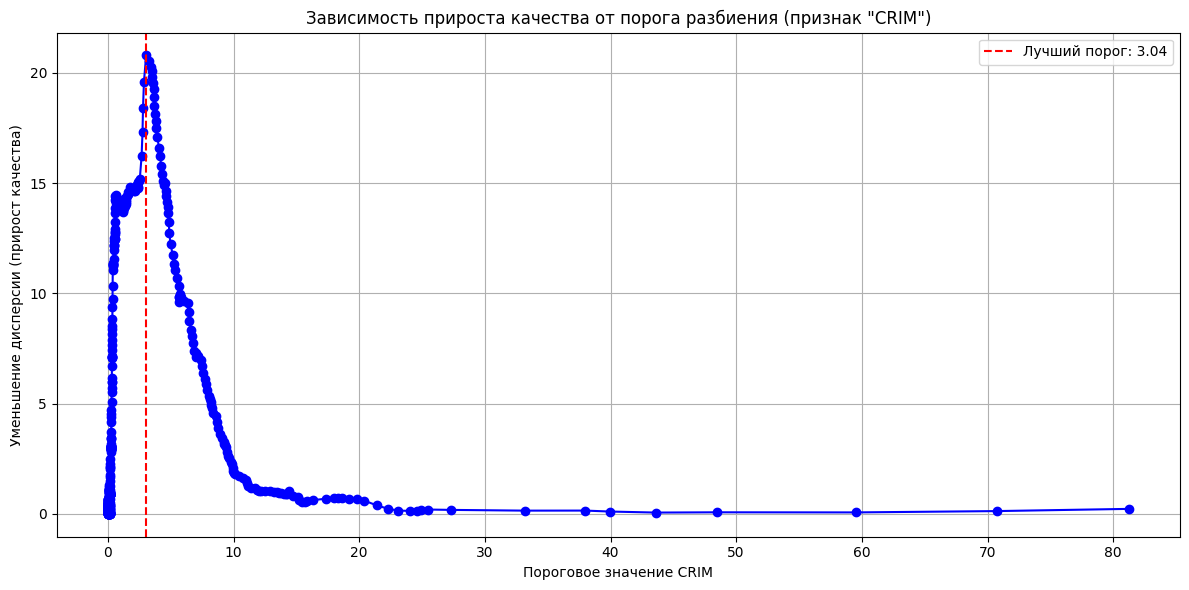

In [6]:
import matplotlib.pyplot as plt

feature_vector = df['CRIM'].values
target_vector = df['MEDV'].values

thresholds, gains, threshold_best, gain_best = find_best_split(
    feature_vector,
    target_vector,
    task='regression',
    feature_type='real'
)

plt.figure(figsize=(12, 6))
plt.plot(thresholds, gains, marker='o', linestyle='-', color='b')
plt.axvline(x=threshold_best, color='r', linestyle='--', label=f'Лучший порог: {threshold_best:.2f}')
plt.title('Зависимость прироста качества от порога разбиения (признак "CRIM")')
plt.xlabel('Пороговое значение CRIM')
plt.ylabel('Уменьшение дисперсии (прирост качества)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [ ]:
from collections import Counter
import numpy as np
from typing import Union, List, Dict

class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x not in ("real", "categorical"), feature_types))):
            raise ValueError("There is unknown feature type")
        
        self._tree = {}
        
        self._feature_types = feature_types
        
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]

            feature_vector = sub_X[:, feature]

            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best

        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: Dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]

        feature_idx = node["feature_split"]
        feature_val = x[feature_idx]

        feature_type = self._feature_types[feature_idx]

        if feature_type == "real":
            threshold = node["threshold"]
            if feature_val <= threshold:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif feature_type == "categorical":
            category = node["category_split"]
            if feature_val == category:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError(f"Unknown feature type {feature_type}")
            
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("students.csv")
df = df.drop('Unnamed: 0', axis=1)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

feature_names = df.columns[:-1]

print("Форма данных:", df.shape)
print(df.head())

Форма данных: (258, 6)
    STG   SCG   STR   LPR   PEG  UNS
0  0.00  0.00  0.00  0.00  0.00    0
1  0.08  0.08  0.10  0.24  0.90    1
2  0.06  0.06  0.05  0.25  0.33    0
3  0.10  0.10  0.15  0.65  0.30    1
4  0.08  0.08  0.08  0.98  0.24    0


## Один график с 5 кривыми: "порог — значение критерия Джини"

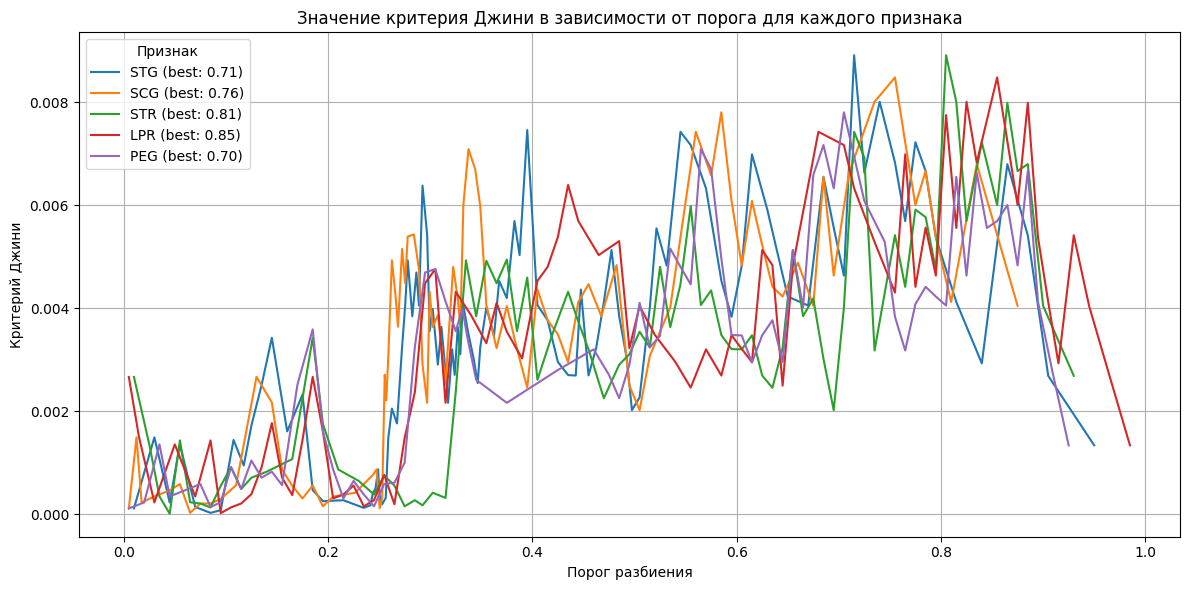

In [18]:
plt.figure(figsize=(12, 6))

for i, name in enumerate(feature_names):
    feature_vector = X[:, i]
    
    thresholds, ginis, threshold_best, gini_best = find_best_split(
        feature_vector, y, task="classification", feature_type="real"
    )
    
    plt.plot(thresholds, ginis, label=f'{name} (best: {threshold_best:.2f})')

plt.title('Значение критерия Джини в зависимости от порога для каждого признака')
plt.xlabel('Порог разбиения')
plt.ylabel('Критерий Джини')
plt.grid(True)
plt.legend(title='Признак')
plt.tight_layout()
plt.show()

## Пять диаграмм рассеяния: "значение признака — класс"

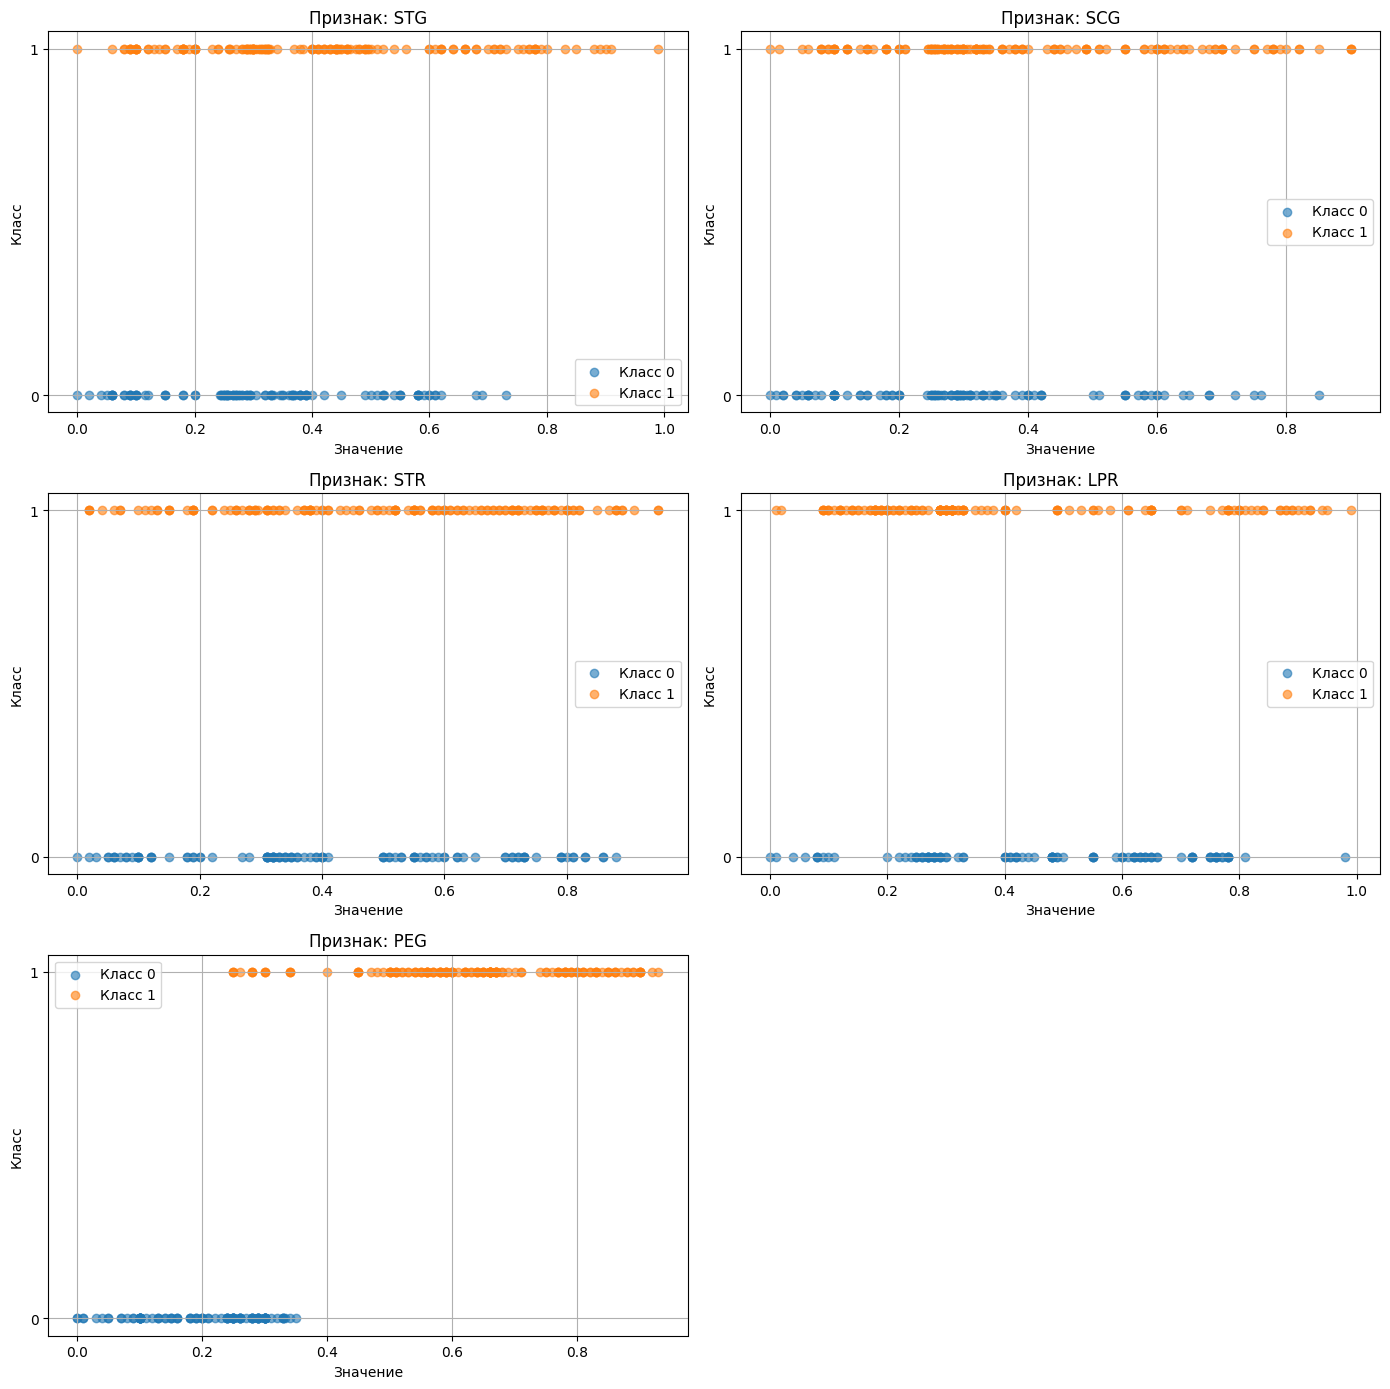

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = axes.flatten()

for i, name in enumerate(feature_names):
    feature = X[:, i]
    class_0 = feature[y == 0]
    class_1 = feature[y == 1]

    ax = axes[i]
    ax.scatter(class_0, np.zeros_like(class_0), alpha=0.6, label='Класс 0')
    ax.scatter(class_1, np.ones_like(class_1), alpha=0.6, label='Класс 1')
    ax.set_title(f'Признак: {name}')
    ax.set_xlabel('Значение')
    ax.set_ylabel('Класс')
    ax.set_yticks([0, 1])
    ax.legend()
    ax.grid(True)

axes[-1].axis('off')

plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

* Вопрос: Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева?

Ответ: По признаку с наименьшим значением Джини , так как он даёт лучшее разделение классов.

* Вопрос: Согласуется ли этот результат с визуальной оценкой диаграмм рассеяния?

Ответ: Да, если признак хорошо разделяет классы по Джини, это будет видно и на диаграмме рассеяния — классы будут слабо перемешаны.

* Вопрос: Как бы вы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально?

Ответ: Кривая имеет чётко выраженный минимум — резкий провал в районе оптимального порога.

* Вопрос: Чем отличаются кривые для признаков, по которым деление практически невозможно?

Ответ: Они имеют плавный или почти плоский ход без явного минимума , что указывает на слабую информативность признака.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

columns = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population', 'habitat'
]

df = pd.read_csv("agaricus-lepiota.data", names=columns)

le = LabelEncoder()
df_encoded = df.apply(le.fit_transform)

X = df_encoded.drop(columns=['class']).values
y = df_encoded['class'].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

feature_types = ['categorical'] * X.shape[1]

tree = DecisionTree(feature_types=feature_types, task='classification')
tree.fit(X_train, y_train)

# Делаем предсказания
y_pred = tree.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(acc, 4)}")

Accuracy: 0.9946


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [31]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [32]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

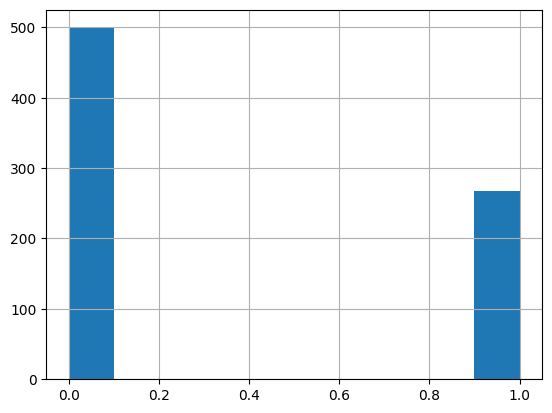

In [33]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
X = data.drop(columns=['Outcome'])
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

print("\nShapes after splitting:")
print(f"Train-train: {X_train_train.shape[0]} ({100 * X_train_train.shape[0] / data.shape[0]:.2f}% of total)")
print(f"Train-val:   {X_train_val.shape[0]} ({100 * X_train_val.shape[0] / data.shape[0]:.2f}% of total)")
print(f"Test:        {X_test.shape[0]} ({100 * X_test.shape[0] / data.shape[0]:.2f}% of total)")


Shapes after splitting:
Train-train: 375 (48.83% of total)
Train-val:   162 (21.09% of total)
Test:        231 (30.08% of total)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

X = data.drop(columns=['Outcome'])
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

max_depth_values = [2, 3, 4, 5, 6, 7, None]
min_samples_leaf_values = [1, 2, 3, 4, 5]

best_f1 = 0
best_params = {}

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        tree = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        tree.fit(X_train_train, y_train_train)

        y_pred = tree.predict(X_train_val)

        f1 = f1_score(y_train_val, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_params = {
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf
            }

print("\nЛучшая пара гиперпараметров:")
print(best_params)
print("F1 на валидации:", best_f1)

final_tree = DecisionTreeClassifier(**best_params, random_state=42)
final_tree.fit(X_train, y_train)

y_pred = final_tree.predict(X_test)
y_proba = final_tree.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\nМетрики на тестовой выборке:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")


Лучшая пара гиперпараметров:
{'max_depth': 6, 'min_samples_leaf': 3}
F1 на валидации: 0.6666666666666666

Метрики на тестовой выборке:
Accuracy:  0.7100
Precision: 0.5714
Recall:    0.6500
F1:        0.6082
ROC AUC:   0.7863


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [36]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

base_tree = DecisionTreeClassifier(random_state=42)

bagging = BaggingClassifier(
    base_estimator=base_tree,
    n_estimators=50,
    random_state=42
)

bagging.fit(X_train, y_train)

y_pred = bagging.predict(X_test)
y_proba = bagging.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("Метрики модели BaggingClassifier на тестовой выборке:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

Метрики модели BaggingClassifier на тестовой выборке:
Accuracy:  0.7489
Precision: 0.6310
Recall:    0.6625
F1:        0.6463
ROC AUC:   0.8083


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
max_depth_values = [2, 3, 4, 5, 6, 7, None]
min_samples_split_values = [2, 4, 6, 8]

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

best_f1 = 0
best_params = {}

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        model = RandomForestClassifier(
            n_estimators=50,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42,
            n_jobs=-1
        )

        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
        mean_f1 = scores.mean()

        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_params = {
                'max_depth': max_depth,
                'min_samples_split': min_samples_split
            }

print("\nЛучшая пара гиперпараметров (Random Forest):")
print(best_params)
print("Среднее значение F1 на кросс-валидации:", best_f1)

rf = RandomForestClassifier(
    n_estimators=50,
    **best_params,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\nМетрики случайного леса на тестовой выборке:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")


Лучшая пара гиперпараметров (Random Forest):
{'max_depth': 7, 'min_samples_split': 8}
Среднее значение F1 на кросс-валидации: 0.6490149671580279

Метрики случайного леса на тестовой выборке:
Accuracy:  0.7273
Precision: 0.6104
Recall:    0.5875
F1:        0.5987
ROC AUC:   0.8026


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

n_estimators: 10, ROC AUC: 0.8051
n_estimators: 30, ROC AUC: 0.8056
n_estimators: 50, ROC AUC: 0.8029
n_estimators: 70, ROC AUC: 0.8028
n_estimators: 90, ROC AUC: 0.8065
n_estimators: 110, ROC AUC: 0.8053
n_estimators: 130, ROC AUC: 0.8045
n_estimators: 150, ROC AUC: 0.8057
n_estimators: 170, ROC AUC: 0.8050
n_estimators: 190, ROC AUC: 0.8050


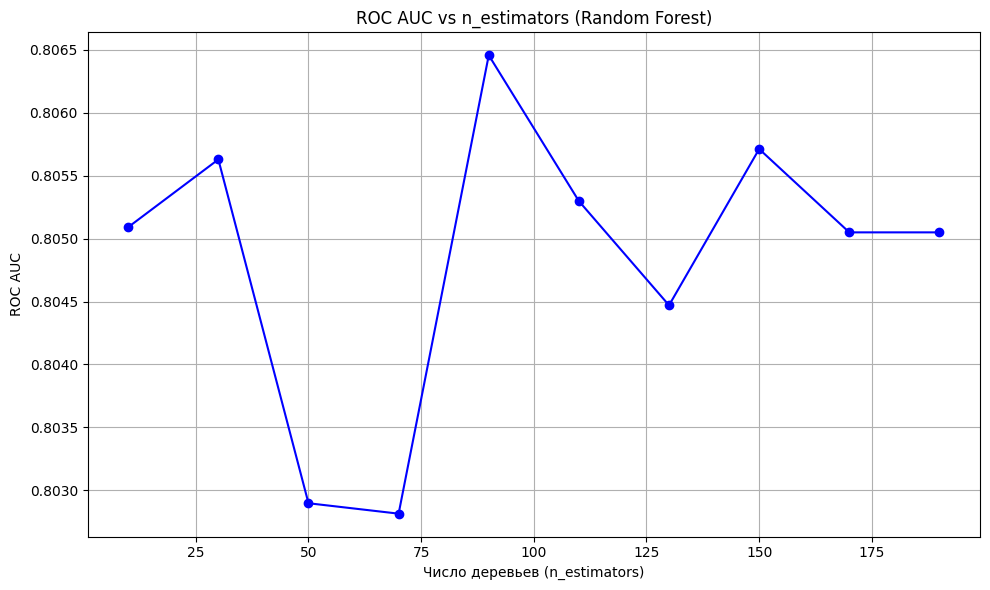

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

n_estimators_values = np.arange(10, 210, 20)

auc_scores = []

for n in n_estimators_values:
    model = RandomForestClassifier(
        n_estimators=n,
        max_depth=5,
        min_samples_split=4,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)
    
    print(f"n_estimators: {n}, ROC AUC: {auc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, auc_scores, marker='o', linestyle='-', color='b')
plt.title('ROC AUC vs n_estimators (Random Forest)')
plt.xlabel('Число деревьев (n_estimators)')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.tight_layout()
plt.show()

## Выводы:
В целом, ROC AUC увеличивается с ростом числа деревьев , что подтверждает положительное влияние ансамблевого подхода (бэггинга) на качество модели.
Однако зависимость не является монотонной — график имеет несколько пиков и спадов.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?


Важность признаков:
                    Feature  Importance
1                   Glucose    0.342299
5                       BMI    0.171841
7                       Age    0.138119
6  DiabetesPedigreeFunction    0.077992
4                   Insulin    0.073435
0               Pregnancies    0.071925
2             BloodPressure    0.065462
3             SkinThickness    0.058927


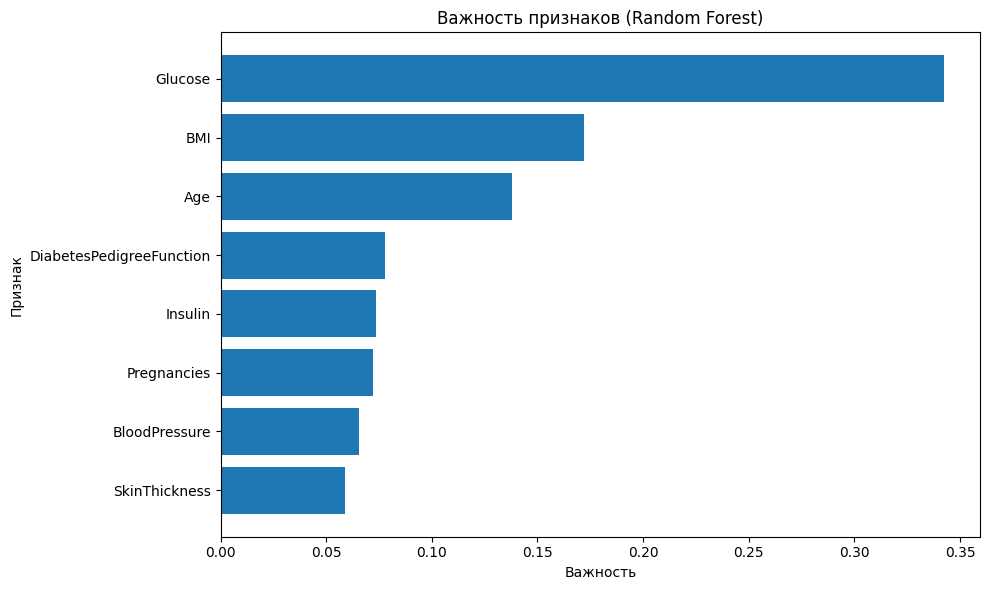


Самый важный признак: Glucose


In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Обучаем лучшую модель случайного леса (из Задания 3.4)
best_params = {'max_depth': 7, 'min_samples_split': 8}

rf = RandomForestClassifier(
    n_estimators=50,
    **best_params,
    random_state=42
)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
features = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nВажность признаков:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.title('Важность признаков (Random Forest)')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

top_feature = feature_importance_df.iloc[0]['Feature']
print(f"\nСамый важный признак: {top_feature}")